In [1]:
import redback
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from redback.simulate_transients import SimulateGenericTransient
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

09:47 bilby INFO    : Running bilby version: 2.1.1
09:47 redback INFO    : Running redback version: 1.0.2


In [2]:
#tophat + two component
def combined_signal(time, redshift, av, bands, num_points, noise, thv, loge0, thc, logn0, p, logepse, logepsb, ksin, g0, mej1, mej2,
                   vej1, vej2, kappa1, kappa2, temp_floor1, temp_floor2 ):
    """
    Function to combine afterglow and kilonova model flux densities
    Time specified is max time
    """
    frequency = np.array(redback.utils.bands_to_frequency(bands))
    times= np.linspace(0.01,time,100)
    
    model_kwargs = {'output_format':'flux_density', 'frequency':frequency}
    
    afterglow_params={}
    afterglow_params['base_model']= 'tophat'
    afterglow_params['redshift'] = redshift
    afterglow_params['av'] = av
    afterglow_params['loge0'] = loge0
    afterglow_params['logn0'] = logn0 
    afterglow_params['p'] = p
    afterglow_params['logepse'] = logepse
    afterglow_params['logepsb'] = logepsb
    afterglow_params['ksin'] = ksin
    afterglow_params['g0'] = g0
    afterglow_params['thv']= thv
    afterglow_params['thc'] = thc
    
    kilonova_params={}
    kilonova_params['base_model']= 'two_component_kilonova_model'
    kilonova_params['redshift'] = redshift
    kilonova_params['av']= av
    kilonova_params['mej_1'] = mej1
    kilonova_params['temperature_floor_1'] = temp_floor1 #min temp of expanding photosphere
    kilonova_params['kappa_1'] = kappa1 
    kilonova_params['vej_1'] = vej1
    kilonova_params['mej_2'] = mej2 
    kilonova_params['temperature_floor_2'] = temp_floor2 
    kilonova_params['kappa_2'] = kappa2
    kilonova_params['vej_2'] = vej2
    
    afterglow_obs= SimulateGenericTransient(model='extinction_with_afterglow_base_model', parameters=afterglow_params,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs, 
                                            multiwavelength_transient=True, noise_term=noise)

    kn_obs= SimulateGenericTransient(model='extinction_with_kilonova_base_model', parameters=kilonova_params,times=times, 
                                     data_points=num_points, model_kwargs=model_kwargs, multiwavelength_transient=True,
                                     noise_term=noise)
    
    merged_data = pd.concat([afterglow_obs.data, kn_obs.data],ignore_index=True)
    print(merged_data)
    
    transient = redback.transient.Transient(name='my_transient', flux_density=merged_data['output'].values,
                                      time=merged_data['time'].values, data_mode='flux_density',
                                      flux_density_err=merged_data['output_error'].values, frequency=merged_data['frequency'].values)
    return transient


         time     frequency   true_output        output  output_error
0    0.010000  3.087381e+14  1.025365e-28  9.127117e-29  5.126824e-30
1    0.010000  3.972879e+14  7.428521e-29  7.011552e-29  3.714260e-30
2    0.514949  6.210931e+14  4.713669e-18  4.739692e-18  2.356834e-19
3    1.524848  3.087381e+14  1.591781e-14  1.642445e-14  7.958905e-16
4    2.029798  3.087381e+14  1.021687e-13  1.035495e-13  5.108434e-15
..        ...           ...           ...           ...           ...
95  43.940606  3.972879e+14  2.834761e-04  2.932062e-04  1.417381e-05
96  45.455455  6.210931e+14  2.859862e-06  2.595364e-06  1.429931e-07
97  47.475253  3.087381e+14  1.417301e-03  1.518177e-03  7.086507e-05
98  47.980202  3.449498e+14  7.628462e-04  7.188250e-04  3.814231e-05
99  50.000000  3.087381e+14  1.438996e-03  1.497207e-03  7.194979e-05

[100 rows x 5 columns]


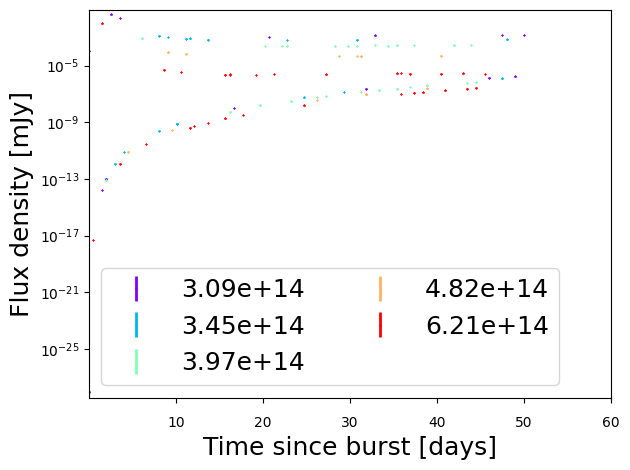

<Axes: xlabel='Time since burst [days]', ylabel='Flux density [mJy]'>

In [3]:
bands = ['lsstg', 'lsstr', 'lssti','lsstz','lssty']
transient= combined_signal(50, 0.01, 1, bands, 50, 0.05, 0.5, 52.5, 0.01, -2, 2.1, -1, -1, 0.4, 1000.0, 0.015, 0.01,
                           0.1, 0.2, 1.0, 25.0, 2000, 2000)

transient.plot_data(filters=transient.unique_frequencies)


In [4]:
frequencies

afterglow_params={}
afterglow_params['base_model']= 'tophat_from_emulator'
afterglow_params['loge0'] = 49.5
afterglow_params['logn0'] = -0.5 
afterglow_params['p'] = 2.13
afterglow_params['logepse'] = -1.25
afterglow_params['logepsb'] = -2.5
afterglow_params['ksin'] = 1
afterglow_params['g0'] = 1000
afterglow_params['thv']= 0.4
afterglow_params['thc'] = 0.06
afterglow_params['frequency']=4e14
    
kilonova_params={}
kilonova_params['base_model']= 'two_layer_stratified_kilonova'
kilonova_params['mej'] = 0.03
kilonova_params['beta'] = 4 
kilonova_params['kappa'] = 3
kilonova_params['vej_1']=0.1
kilonova_params['vej_2'] = 0.4
kilonova_params['frequency']=4e14


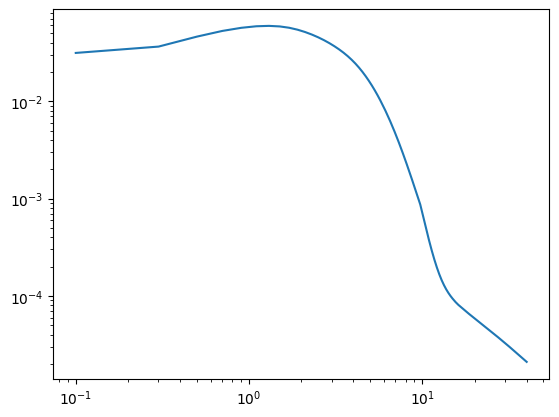

In [5]:
time=np.linspace(0.1,40,200)
test_flux = redback.transient_models.combined_models.afterglow_and_optical(time=time, redshift=0.01, av=0.5, model_type= 'kilonova',
                                                                          output_format='flux_density', afterglow_kwargs=afterglow_params,
                                                                          optical_kwargs=kilonova_params)
ax=plt.subplot()
ax.loglog(time,test_flux)

In [6]:
times= np.linspace(0.1,40,200)
num_points=500
noise=0.05

bands = ['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']
frequencies=[5e9, 2e17]
bandfreqs = (redback.utils.bands_to_frequency(bands))
print(bandfreqs)
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

ag={}
ag['loge0'] = 49.5
ag['logn0'] = 0.5 
ag['p'] = 2.3
ag['logepse'] = -1.25
ag['logepsb'] = -2.5
ag['ksin'] = 1
ag['g0'] = 1000
ag['thv']= 0.5
ag['thc'] = 0.06
ag['base_model']='tophat'

kn={}
kn['mej']=0.03
kn['vej_1']=0.1
kn['vej_2']=0.4
kn['kappa']=2
kn['beta']=4
kn['base_model']='two_layer_stratified_kilonova'


parameters = {'redshift':0.01, 'av':0.5, 'model_type':'kilonova', 'afterglow_kwargs':ag, 'optical_kwargs':kn}
model_kwargs= {'frequency':frequencies, 'output_format':'flux_density'}

combined_model =  SimulateGenericTransient(model='afterglow_and_optical', parameters=parameters,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs,
                                            multiwavelength_transient=True, noise_term=noise)
combined_model.data

[1.94770377e+14 2.57913110e+14 3.08738117e+14 3.44949775e+14
 3.97287891e+14 4.81730482e+14 6.21093083e+14 8.16711950e+14
 1.14683976e+15]


time     frequency   true_output        output  output_error
0     0.100000  2.000000e+17  9.761603e-04  1.094271e-03  4.880802e-05
1     0.100000  3.449498e+14  1.005154e-01  9.737798e-02  5.025772e-03
2     0.100000  5.000000e+09  1.297195e+01  1.376041e+01  6.485975e-01
3     0.300503  2.000000e+17  1.953422e-04  2.029763e-04  9.767112e-06
4     0.501005  2.000000e+17  9.315807e-05  9.979351e-05  4.657904e-06
..         ...           ...           ...           ...           ...
495  39.799497  5.000000e+09  3.431200e-02  3.322304e-02  1.715600e-03
496  39.799497  6.210931e+14  9.745069e-06  1.029005e-05  4.872534e-07
497  40.000000  1.947704e+14  3.337165e-05  3.267041e-05  1.668582e-06
498  40.000000  2.000000e+17  1.478337e-07  1.564630e-07  7.391685e-09
499  40.000000  4.817305e+14  1.341146e-05  1.250658e-05  6.705731e-07

[500 rows x 5 columns]

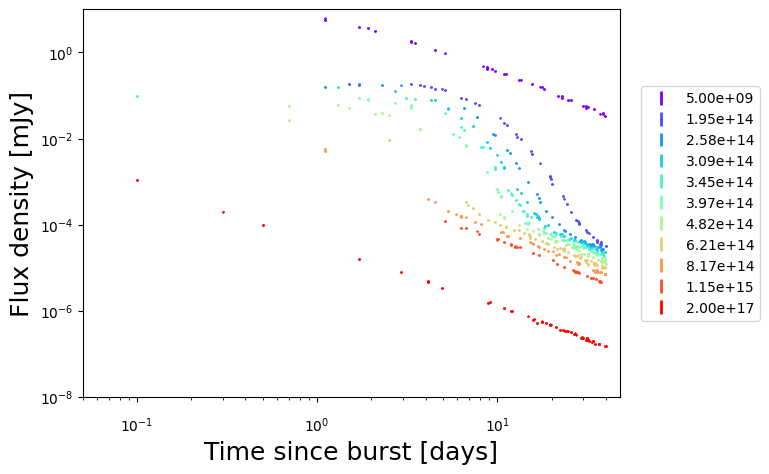

In [7]:
transient = redback.transient.Transient(name='my_transient', flux_density=combined_model.data['output'].values,
                                      time=combined_model.data['time'].values, data_mode='flux_density',
                                      flux_density_err=combined_model.data['output_error'].values, frequency=combined_model.data['frequency'].values)
    
ax= transient.plot_data(filters=transient.unique_frequencies, show=False)
ax.set_ylim(10e-9,10)
ax.loglog()
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

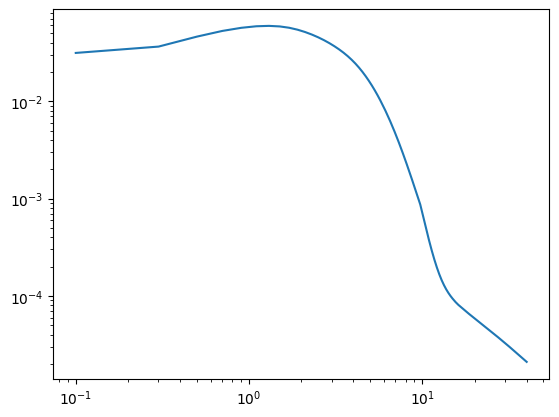

In [8]:
time=np.linspace(0.1,40,200)

flux=redback.transient_models.combined_models.tophat_and_twolayerstratified(time,redshift=0.01,av=0.5,thv=0.4, loge0=49.5, thc=0.6, 
            logn0=-0.5, p=2.13, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, mej=0.03, output_format='AB_mag', frequency=4e14,
            kappa=3, beta=4, vej_1=0.1, vej_2=0.4)

ax= plt.subplot()
ax.loglog(time,flux)
plt.show()

In [4]:
times= np.linspace(0.1,40,200)
num_points=100
noise=0.2

bands = ['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']
#frequencies=[5e9, 2e17]
frequencies=[]
bandfreqs = (redback.utils.bands_to_frequency(bands))
print(bandfreqs)
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

model_kwargs = {'output_format':'flux_density', 'frequency':frequencies}

agkwargs={}
agkwargs['loge0'] = 51.5
agkwargs['logn0'] = 1
agkwargs['p'] = 2.3
agkwargs['logepse'] = -1.25
agkwargs['logepsb'] = -2.5
agkwargs['xiN'] = 1
agkwargs['g0'] = 1000
agkwargs['thv']= 0.5
agkwargs['thc'] = 0.07
agkwargs['base_model']='tophat_redback'
knkwargs={}
knkwargs['mej']=0.03
knkwargs['vej_1']=0.1
knkwargs['vej_2']=0.4
knkwargs['kappa']=5
knkwargs['beta']=20
knkwargs['base_model']='two_layer_stratified_kilonova'
params={}
params['redshift'] = 0.01
params['av'] = 0.5
params['model_type']='kilonova'
params['afterglow_kwargs']=agkwargs
params['optical_kwargs']=knkwargs
    
combined_model =  SimulateGenericTransient(model='afterglow_and_optical', parameters=params,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs, 
                                            multiwavelength_transient=True, noise_term=noise)
combined_model.data

[1.952e+14 2.601e+14 3.083e+14 3.454e+14 3.983e+14 4.825e+14 6.273e+14
 8.152e+14 1.141e+15]


time     frequency  true_output    output  output_error
0    0.100000  1.141000e+15     0.000348  0.000405      0.000070
1    0.100000  3.454000e+14     0.002476  0.003011      0.000495
2    0.300503  1.952000e+14     0.006604  0.005989      0.001321
3    0.501005  1.141000e+15     0.000152  0.000156      0.000030
4    0.701508  1.141000e+15     0.000121  0.000094      0.000024
..        ...           ...          ...       ...           ...
95  38.796985  1.952000e+14     0.000054  0.000072      0.000011
96  39.197990  3.454000e+14     0.000025  0.000019      0.000005
97  39.398492  1.952000e+14     0.000051  0.000040      0.000010
98  39.398492  3.083000e+14     0.000028  0.000023      0.000006
99  39.598995  1.952000e+14     0.000050  0.000052      0.000010

[100 rows x 5 columns]

Meta data does not exist for this event.


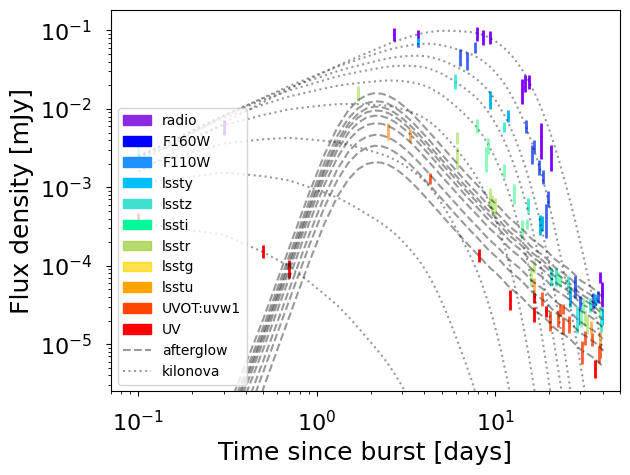

In [5]:
testtransient = redback.transient.Afterglow(name='testtransient', flux_density=combined_model.data['output'].values,
                                      time=combined_model.data['time'].values, data_mode='flux_density',
                                      flux_density_err=combined_model.data['output_error'].values, frequency=combined_model.data['frequency'].values)
   
ax= testtransient.plot_data(filters=frequencies, show=False, markersize=20)

for f in frequencies:
    agkwargs['frequency']=f
    knkwargs['frequency']=f
    ag= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(times, **agkwargs, av=0.5, redshift=0.01)
    kn=redback.transient_models.extinction_models.extinction_with_kilonova_base_model(times, **knkwargs,av=0.5, redshift=0.01)
    ax.plot(times,ag, ls='--', c='k', alpha=0.4)
    ax.plot(times,kn, ls=':', c='k', alpha=0.4)

#ax.set_ylim(10e-9,10)
ax.set_xlim(0.07,50)
ax.loglog()
f1 = mpatches.Patch(color='blueviolet', label='radio')
f2 = mpatches.Patch(color='b', label='F160W')
f3 = mpatches.Patch(color='dodgerblue', label='F110W')
f4 = mpatches.Patch(color='deepskyblue', label='lssty')
f5 = mpatches.Patch(color='turquoise', label='lsstz')
f6 = mpatches.Patch(color='mediumspringgreen', label='lssti')
f7 = mpatches.Patch(color='yellowgreen', label='lsstr',alpha=0.7)
f8 = mpatches.Patch(color='gold', label='lsstg', alpha=0.7)
f9 = mpatches.Patch(color='orange', label='lsstu')
f10=mpatches.Patch(color='orangered', label='UVOT:uvw1')
f11=mpatches.Patch(color='red', label='UV')
agline=  Line2D([0],[0],color='k', ls='--', label='afterglow', alpha=0.4)
knline=  Line2D([0],[0],color='k', ls=':', label='kilonova', alpha=0.4)
plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11, agline,knline],loc='lower left',bbox_to_anchor=(0, 0))

#plt.savefig('actual_fit_onax.png', dpi='figure')
plt.show()

In [10]:
result = redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/tophat_from_emulator/GRBsignificant_off_result.json')

In [17]:
redback.utils.calc_flux_density_from_ABmag(28)

<Quantity 2.29086765e-05 mJy>

17:33 bilby INFO    : Running for label 'GRBtesttransient', output will be saved to 'GRBData/afterglow/flux_density//two_layer_stratified_kilonova'
17:34 bilby INFO    : Analysis priors:
17:34 bilby INFO    : mej=Uniform(minimum=0.01, maximum=0.05, name='mej', latex_label='$M_{\\mathrm{ej}}~(M_\\odot)$', unit=None, boundary=None)
17:34 bilby INFO    : vej_1=Uniform(minimum=0.05, maximum=0.2, name='vej_1', latex_label='$v_{\\mathrm{ej}~1}~(c)$', unit=None, boundary=None)
17:34 bilby INFO    : vej_2=Uniform(minimum=0.3, maximum=0.5, name='vej_2', latex_label='$v_{\\mathrm{ej}~2}~(c)$', unit=None, boundary=None)
17:34 bilby INFO    : kappa=Uniform(minimum=1, maximum=30, name='kappa', latex_label='$\\kappa~(\\mathrm{cm}^{2}/\\mathrm{g})$', unit=None, boundary=None)
17:34 bilby INFO    : beta=Uniform(minimum=3.1, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
17:34 bilby INFO    : redshift=0.01
17:34 bilby INFO    : xiN=1
17:34 bilby INFO    : Analysis likelihood 

it=  6533 logz=216.49772938590


17:45 bilby INFO    : Sampling time: 0:10:53.960452
17:45 bilby INFO    : Summary of results:
nsamples: 7034
ln_noise_evidence: -205.698
ln_evidence: 216.709 +/-  0.139
ln_bayes_factor: 422.408 +/-  0.139

Meta data does not exist for this event.


<function matplotlib.pyplot.show(close=None, block=None)>

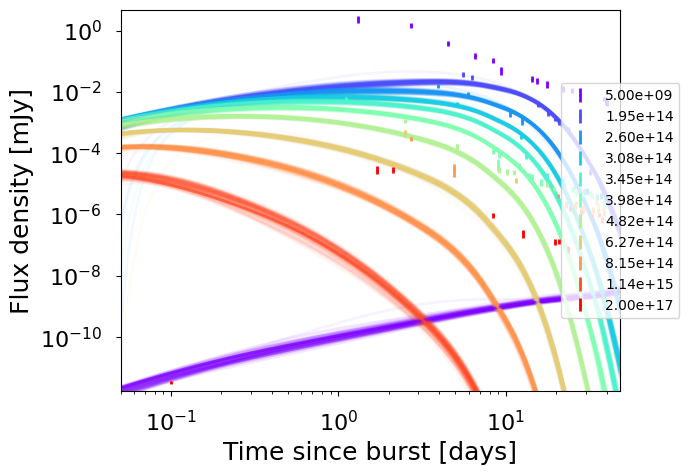

In [147]:
model='two_layer_stratified_kilonova'
injection_parameters= knkwargs
model_kwargs = dict(frequency=testtransient.filtered_frequencies, output_format='flux_density')
priors = redback.priors.get_priors(model=model)
priors['redshift']=0.01
priors['xiN']=1
priors

result = redback.fit_model(transient=testtransient, model=model, sampler='nestle', model_kwargs=model_kwargs,
                           prior=priors, nlive=500, plot=False, resume=True,injection_parameters=injection_parameters)
ax=result.plot_lightcurve(show=False)
ax.loglog()
plt.legend(loc='center',bbox_to_anchor=(1, 0.5))
plt.show

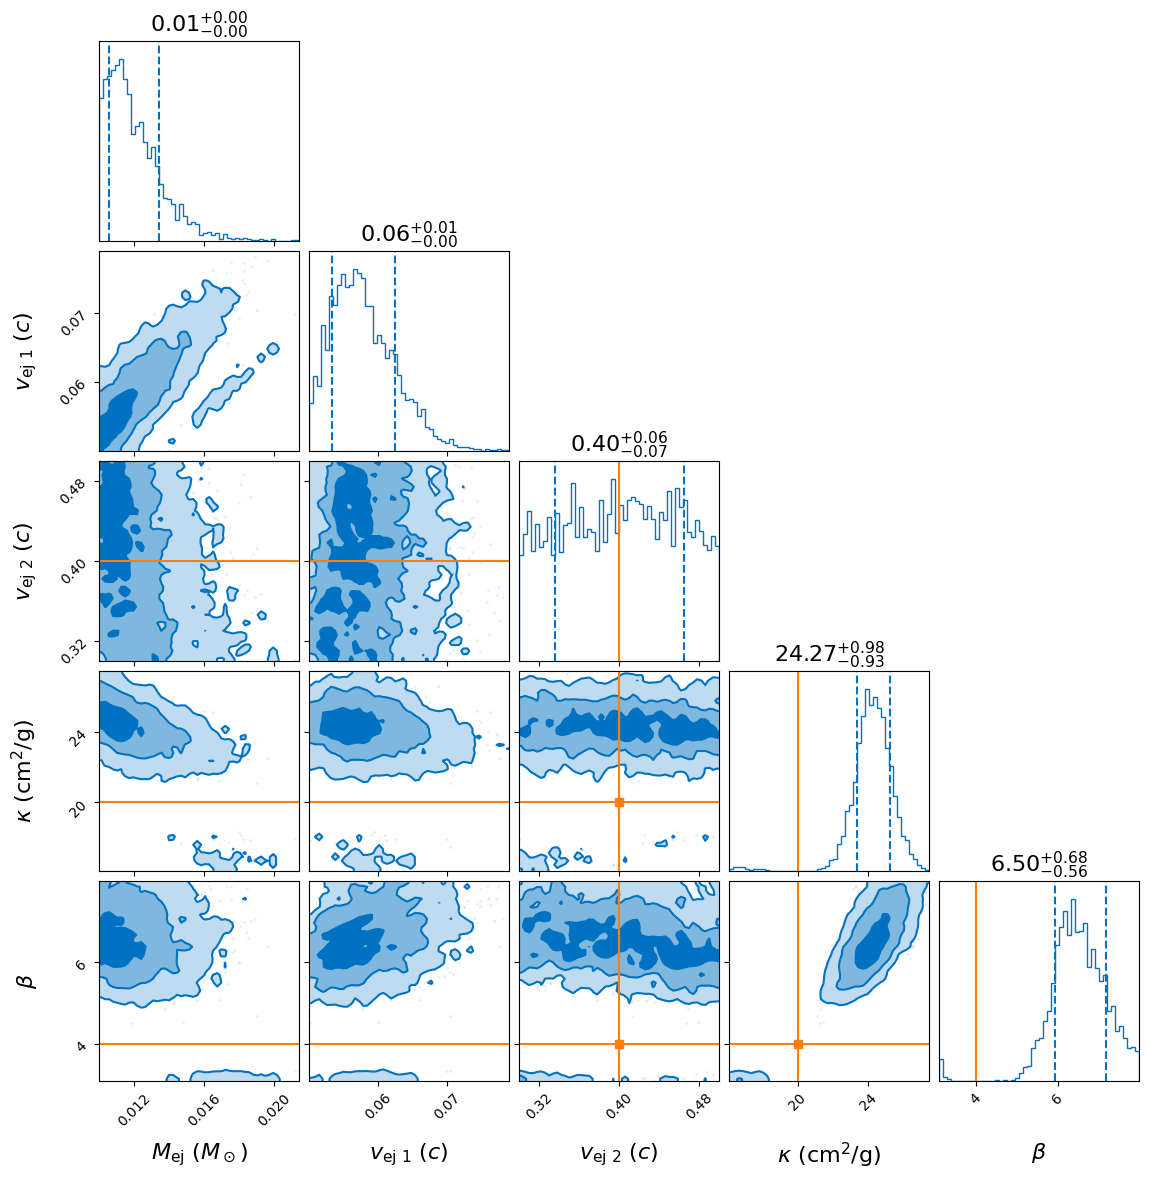

In [148]:
result.plot_corner()

In [47]:
transient.unique_frequencies

array([5.000e+09, 1.952e+14, 2.601e+14, 3.083e+14, 3.454e+14, 3.983e+14,
       4.825e+14, 6.273e+14, 8.152e+14, 1.141e+15, 2.000e+17])

In [4]:
model='two_layer_stratified_kilonova'
injection_parameters= params
model_kwargs = dict(frequency=kntransient.filtered_frequencies, output_format='flux_density')
priors = redback.priors.get_priors(model=model)
priors['redshift']=0.01
#priors['beta']=4
priors

{'redshift': 0.01,
 'mej': Uniform(minimum=0.01, maximum=0.05, name='mej', latex_label='$M_{\\mathrm{ej}}~(M_\\odot)$', unit=None, boundary=None),
 'vej_1': Uniform(minimum=0.05, maximum=0.2, name='vej_1', latex_label='$v_{\\mathrm{ej}~1}~(c)$', unit=None, boundary=None),
 'vej_2': Uniform(minimum=0.3, maximum=0.5, name='vej_2', latex_label='$v_{\\mathrm{ej}~2}~(c)$', unit=None, boundary=None),
 'kappa': Uniform(minimum=1, maximum=30, name='kappa', latex_label='$\\kappa~(\\mathrm{cm}^{2}/\\mathrm{g})$', unit=None, boundary=None),
 'beta': Uniform(minimum=3.1, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)}

In [5]:
knresult = redback.fit_model(transient=kntransient, model=model, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=priors, sample='rslice', nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)


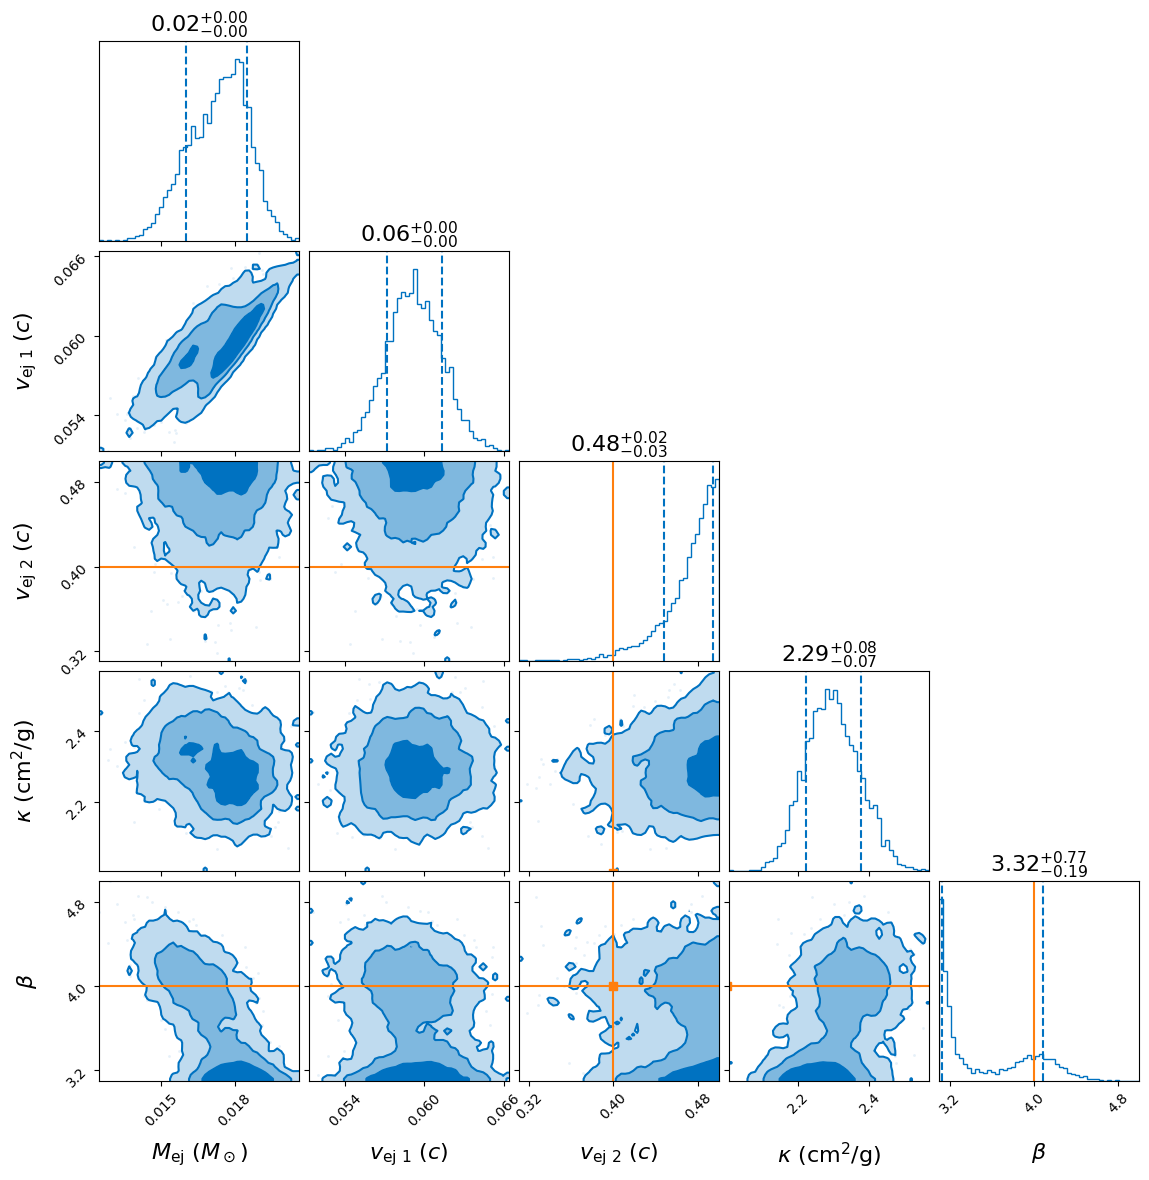

In [8]:
knresult.plot_corner()

In [6]:
knresult.posterior

mej     vej_1     vej_2     kappa      beta  redshift  \
0     0.016767  0.055690  0.403003  2.006919  3.270314      0.01   
1     0.018959  0.065320  0.429562  2.243618  4.122475      0.01   
2     0.013892  0.054212  0.418846  2.142528  4.643098      0.01   
3     0.014412  0.054377  0.326838  2.238878  4.845852      0.01   
4     0.012902  0.055319  0.498238  2.347892  5.003564      0.01   
...        ...       ...       ...       ...       ...       ...   
4989  0.018241  0.059571  0.499159  2.295563  3.116467      0.01   
4990  0.018171  0.059408  0.492342  2.263143  3.108629      0.01   
4991  0.017918  0.058761  0.492027  2.260046  3.103682      0.01   
4992  0.018298  0.059755  0.495036  2.259456  3.102523      0.01   
4993  0.018167  0.059309  0.494714  2.269625  3.100577      0.01   

      log_likelihood  log_prior  
0          57.991857   1.768903  
1          59.766887   1.768903  
2          59.879257   1.768903  
3          60.015765   1.768903  
4          60.019721   1.768903  
...              ...        ...  
4989       72.854842   1.768903  
4990       72.884610   1.768903  
4991       72.907318   1.768903  
4992       72.975728   1.768903  
4993       73.057409   1.768903  

[4994 rows x 8 columns]

In [3]:
knresult2=redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/two_layer_stratified_kilonova/GRBkntransient2_result.json')


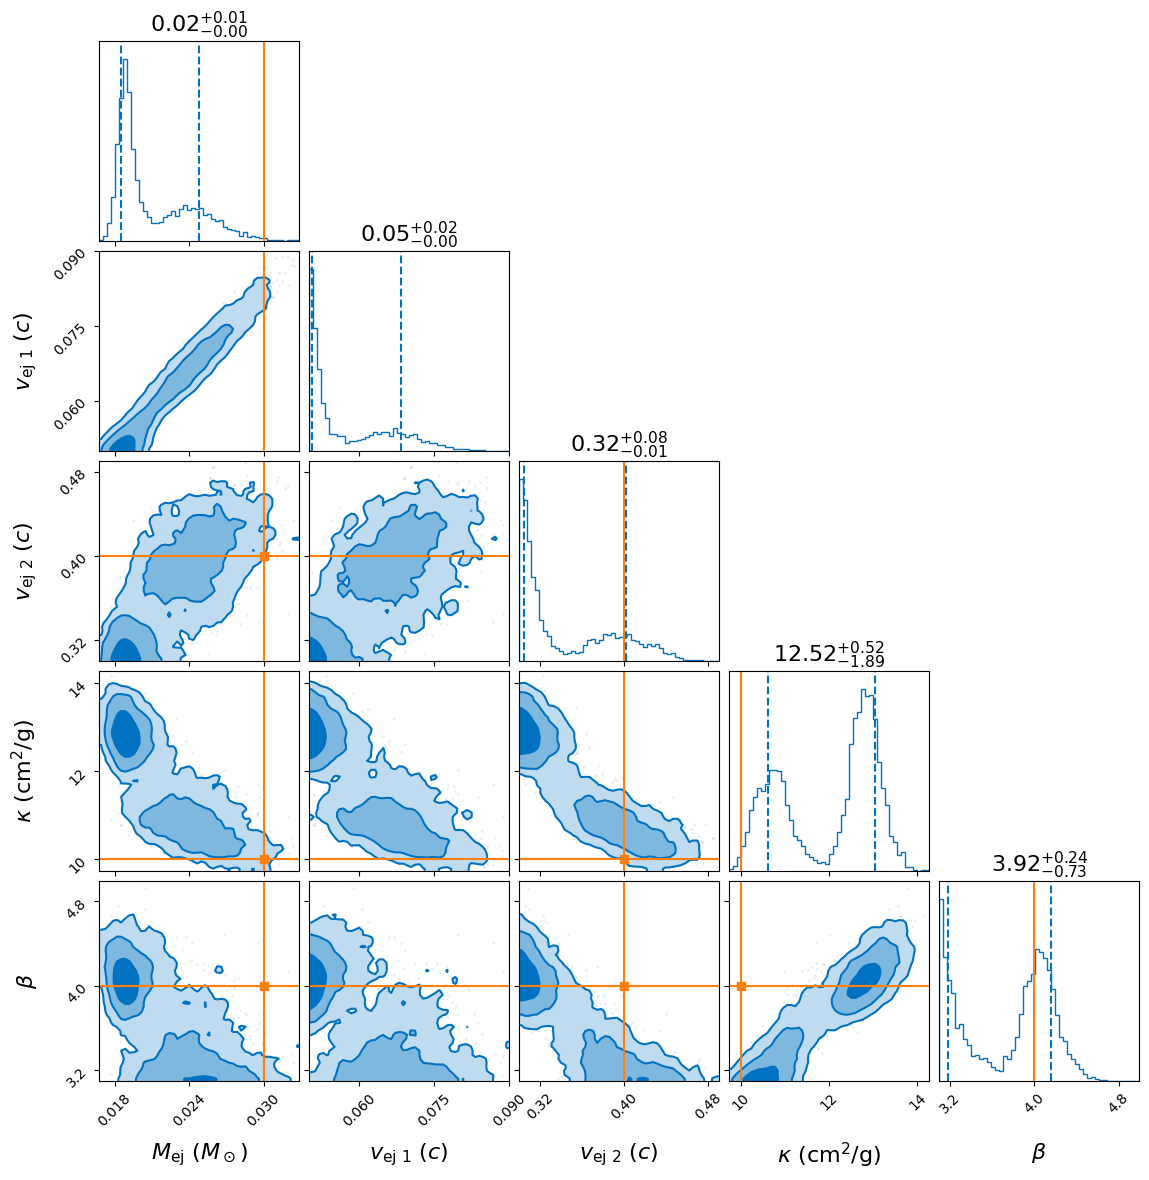

In [29]:
knresult2.plot_corner()

Meta data does not exist for this event.


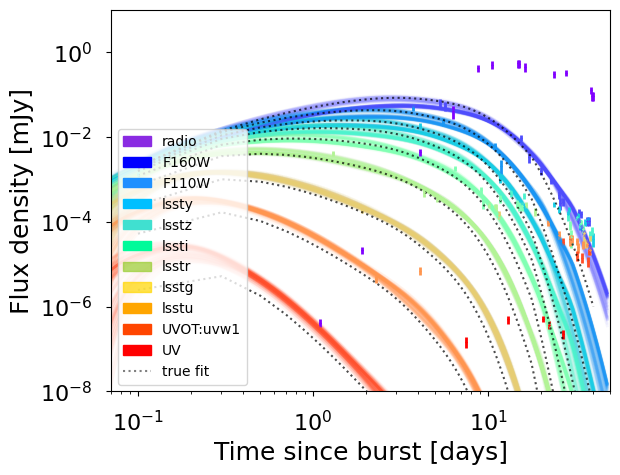

In [11]:
ax=knresult2.plot_lightcurve(show=False)
for f in frequencies:
    kn=redback.transient_models.extinction_models.extinction_with_kilonova_base_model(times, base_model='two_layer_stratified_kilonova', **params, frequency=f, 
                                                                                      output_format='flux_density')
    ax.plot(times,kn, ls=':', c='k', alpha=0.7)

ax.set_ylim(10e-9,10)
ax.set_xlim(0.07,50)
ax.loglog()
f1 = mpatches.Patch(color='blueviolet', label='radio')
f2 = mpatches.Patch(color='b', label='F160W')
f3 = mpatches.Patch(color='dodgerblue', label='F110W')
f4 = mpatches.Patch(color='deepskyblue', label='lssty')
f5 = mpatches.Patch(color='turquoise', label='lsstz')
f6 = mpatches.Patch(color='mediumspringgreen', label='lssti')
f7 = mpatches.Patch(color='yellowgreen', label='lsstr',alpha=0.7)
f8 = mpatches.Patch(color='gold', label='lsstg', alpha=0.7)
f9 = mpatches.Patch(color='orange', label='lsstu')
f10=mpatches.Patch(color='orangered', label='UVOT:uvw1')
f11=mpatches.Patch(color='red', label='UV')
#agline=  Line2D([0],[0],color='k', ls='--', label='afterglow', alpha=0.4)
knline=  Line2D([0],[0],color='k', ls=':', label='true fit', alpha=0.5)
plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,knline],loc='lower left',bbox_to_anchor=(0, 0))

plt.savefig('knonly_lightcurve2.png', dpi='figure')
plt.show()


Meta data does not exist for this event.


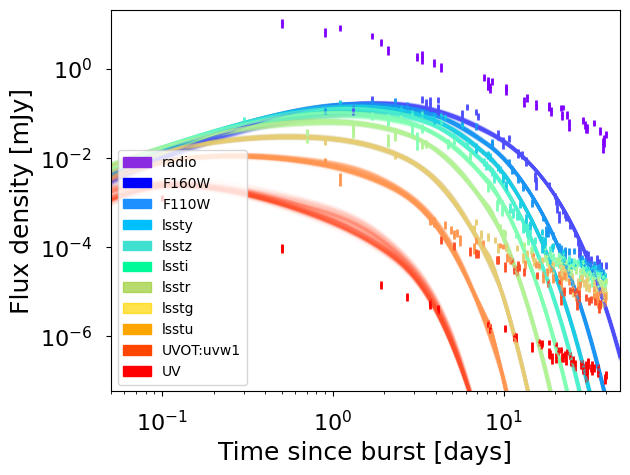

In [17]:
ax=knresult.plot_lightcurve(show=False)
ax.loglog()
f1 = mpatches.Patch(color='blueviolet', label='radio')
f2 = mpatches.Patch(color='b', label='F160W')
f3 = mpatches.Patch(color='dodgerblue', label='F110W')
f4 = mpatches.Patch(color='deepskyblue', label='lssty')
f5 = mpatches.Patch(color='turquoise', label='lsstz')
f6 = mpatches.Patch(color='mediumspringgreen', label='lssti')
f7 = mpatches.Patch(color='yellowgreen', label='lsstr',alpha=0.7)
f8 = mpatches.Patch(color='gold', label='lsstg', alpha=0.7)
f9 = mpatches.Patch(color='orange', label='lsstu')
f10=mpatches.Patch(color='orangered', label='UVOT:uvw1')
f11=mpatches.Patch(color='red', label='UV')
plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11],loc='lower left',bbox_to_anchor=(0, 0))

plt.savefig('knonly_lightcurve.png', dpi='figure')
plt.show()

In [11]:
agtransient = redback.transient.Afterglow(name='agtransient', flux_density=combined_model.data['output'].values,
                                      time=combined_model.data['time'].values, data_mode='flux_density',
                                      flux_density_err=combined_model.data['output_error'].values, frequency=combined_model.data['frequency'].values)

Meta data does not exist for this event.


In [12]:
model2='tophat'
injection_parameters= params
model_kwargs = dict(frequency=agtransient.filtered_frequencies, output_format='flux_density')
that_priors = redback.priors.get_priors(model=model2)
that_priors['redshift']=0.01
that_priors

{'redshift': 0.01,
 'thv': Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None),
 'loge0': Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None),
 'thc': Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}$', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None),
 'p': Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None),
 'logepse': Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}\\epsilon_{e}$', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='logepsb', latex_label='$\\log_{10}\\epsilon_{B}$', unit=None, boundary=None),
 'ksin': Uniform(minimum=0.0, maximum=1.0, name='ksin', latex_label='$\\xi_{N}$', unit=None, boundary=None),
 'g0': Uniform(minimum

In [21]:
agresult = redback.fit_model(transient=agtransient, model=model2, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=that_priors, nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)

06:23 bilby INFO    : Running for label 'GRBmy_transient2', output will be saved to 'GRBData/afterglow/flux_density//tophat'
06:23 bilby INFO    : Analysis priors:
06:23 bilby INFO    : thv=Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None)
06:23 bilby INFO    : loge0=Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
06:23 bilby INFO    : thc=Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}$', unit=None, boundary=None)
06:23 bilby INFO    : logn0=Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)
06:23 bilby INFO    : p=Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None)
06:23 bilby INFO    : logepse=Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}\\epsilon_{e}$', unit=None, boundary=None)
06:23 bilby

25588it [00:00, ?it/s]

RuntimeError: Slice sampler has failed to find a valid point. Some useful output quantities:
u: [0.00245854 0.75101901 0.86439767 0.01570549 0.38818915 0.38476287
 0.90492018 0.20184519 0.50027106]
nstep_left: -5e-324
nstep_right: 5e-324
nstep_hat: 1e-323
u_prop: [0.00245854 0.75101901 0.86439767 0.01570549 0.38818915 0.38476287
 0.90492018 0.20184519 0.50027106]
loglstar: -19772.231642036448
logl_prop: <dynesty.utils.LoglOutput object at 0x7ffad0075e50>
direction: [-9.48714351e-08  3.64746067e-03  4.64398433e-03 -4.88185128e-03
  1.85458182e-03 -1.01009061e-02  9.29394391e-04 -3.72595170e-02
 -1.04696899e-02]


In [ ]:
agresult.plot_corner()

In [ ]:
ax= agresult.plot_lightcurve(show=False)
ax.loglog()
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

In [9]:
transient3= redback.transient.Afterglow(name='my_transient3', flux_density=combined_model.data['output'].values,
                                      time=combined_model.data['time'].values, data_mode='flux_density',
                                      flux_density_err=combined_model.data['output_error'].values, frequency=combined_model.data['frequency'].values)

Meta data does not exist for this event.


In [10]:
model3='tophat_and_twolayerstratified'
injection_parameters= params
model_kwargs = dict(frequency=transient3.filtered_frequencies, output_format='flux_density')
all_priors = redback.priors.get_priors(model=model3)
all_priors['redshift']=0.01
all_priors['av']=0.5
all_priors

{'redshift': 0.01,
 'av': 0.5,
 'thv': Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None),
 'loge0': Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None),
 'thc': Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}$', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None),
 'p': Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None),
 'logepse': Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}\\epsilon_{e}$', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='logepsb', latex_label='$\\log_{10}\\epsilon_{B}$', unit=None, boundary=None),
 'ksin': Uniform(minimum=0.0, maximum=1.0, name='ksin', latex_label='$\\xi_{N}$', unit=None, boundary=None),
 'g0': Uni

In [6]:
result3 = redback.fit_model(transient=transient3, model=model3, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=all_priors, sample='rslice', nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)

In [7]:
result3.posterior

thv      loge0       thc     logn0         p   logepse   logepsb  \
0    1.197852  51.038055  0.056370 -0.075864  2.530516 -2.693570 -0.525863   
1    1.286007  46.193925  0.040223 -3.941607  2.057791 -2.286197 -1.060684   
2    1.297433  45.532774  0.034742 -0.307624  2.910488 -2.185854 -1.459594   
3    0.455394  45.316915  0.046696  1.516947  2.588867 -3.958924 -1.499920   
4    0.971653  47.679924  0.053561 -4.005734  2.116867 -3.064750 -0.652866   
..        ...        ...       ...       ...       ...       ...       ...   
995  0.451246  46.131538  0.080531 -3.573097  2.928790 -4.146062 -0.442071   
996  1.557922  52.191791  0.071541  1.906323  2.278780 -4.554257 -0.308776   
997  1.247735  44.188311  0.023325 -3.450820  2.850864 -1.684442 -3.140491   
998  1.288728  45.814367  0.043085 -0.792482  2.948638 -2.503578 -1.422006   
999  0.642092  51.550089  0.047482 -2.966629  2.938713 -2.179830 -3.268626   

         ksin           g0       mej     vej_1     vej_2      kappa      beta  \
0    0.982517  1256.142507  0.049323  0.131573  0.340541  28.512831  1.557489   
1    0.826232   284.883788  0.045147  0.151623  0.356399  28.688170  1.511730   
2    0.808064  1902.532333  0.048530  0.170057  0.317553  29.938855  1.739169   
3    0.306521  1419.950171  0.049250  0.175435  0.334356  25.963094  2.389071   
4    0.995149   275.574724  0.049684  0.175662  0.359135  28.224716  2.065665   
..        ...          ...       ...       ...       ...        ...       ...   
995  0.601648   529.983045  0.040711  0.181152  0.305938  24.157545  1.929774   
996  0.958817   869.461073  0.042828  0.170278  0.316105  28.522452  2.025669   
997  0.479347  1620.319583  0.046744  0.101772  0.305417  29.784625  1.746337   
998  0.725630  1506.643100  0.048208  0.150356  0.309613  28.636170  1.988518   
999  0.860663  1839.179112  0.034982  0.172212  0.320592  28.814624  1.708504   

     redshift   av  log_likelihood  log_prior  
0        0.01  0.5             0.0 -11.887065  
1        0.01  0.5             0.0 -11.856959  
2        0.01  0.5             0.0 -11.853685  
3        0.01  0.5             0.0 -12.637244  
4        0.01  0.5             0.0 -12.007225  
..        ...  ...             ...        ...  
995      0.01  0.5             0.0 -12.645760  
996      0.01  0.5             0.0 -11.815929  
997      0.01  0.5             0.0 -11.868964  
998      0.01  0.5             0.0 -11.856166  
999      0.01  0.5             0.0 -12.328554  

[1000 rows x 18 columns]

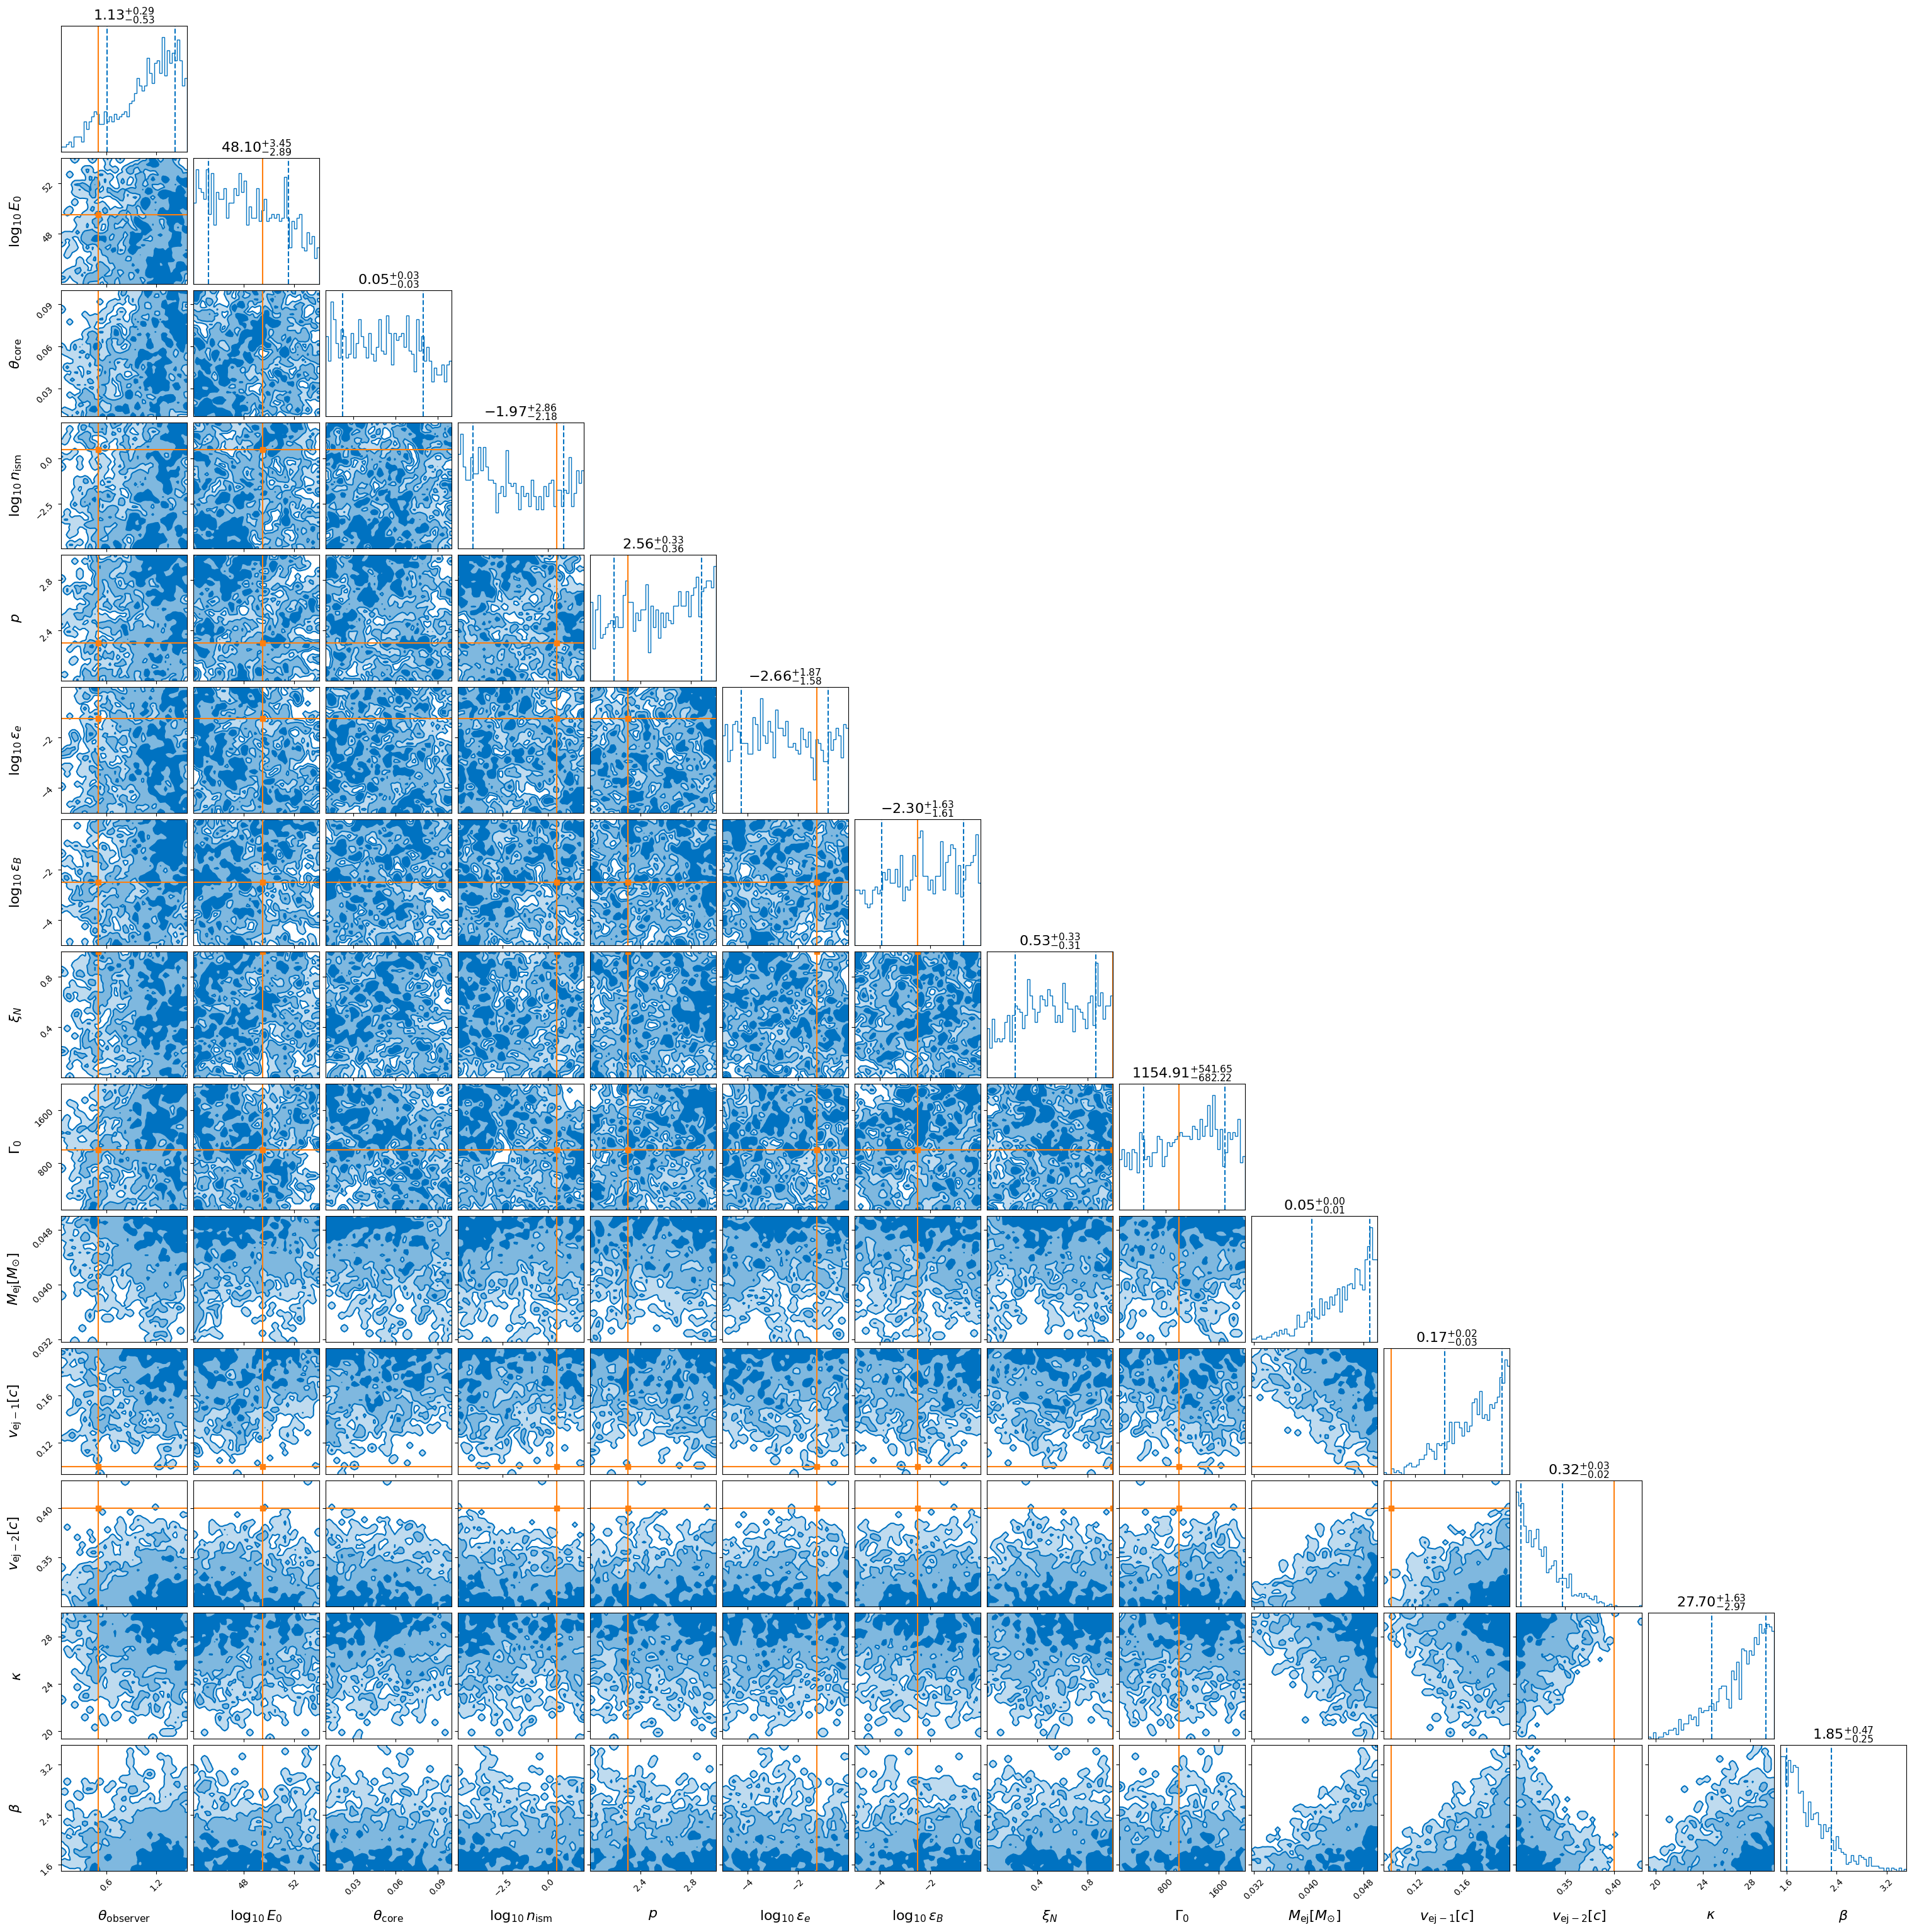

In [8]:
result3.plot_corner()

In [4]:
model_kwargs = {'output_format':'flux_density', 'frequency':frequencies}
lessnoise_model =  SimulateGenericTransient(model='tophat_and_twolayerstratified', parameters=params,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs, 
                                            multiwavelength_transient=True, noise_term=0.01)
lessnoise_model.data

time     frequency   true_output        output  output_error
0     0.300503  2.000000e+17  1.953432e-04  1.941091e-04  1.953432e-06
1     0.300503  3.454000e+14  6.666615e-02  6.730439e-02  6.666615e-04
2     0.300503  5.000000e+09  1.614341e+01  1.619802e+01  1.614341e-01
3     0.501005  2.000000e+17  9.315529e-05  9.300676e-05  9.315529e-07
4     0.501005  2.000000e+17  9.315529e-05  9.335073e-05  9.315529e-07
..         ...           ...           ...           ...           ...
495  39.197990  5.000000e+09  3.524965e-02  3.509266e-02  3.524965e-04
496  39.598995  6.273000e+14  9.700655e-06  9.796123e-06  9.700655e-08
497  40.000000  1.952000e+14  3.327792e-05  3.365357e-05  3.327792e-07
498  40.000000  2.000000e+17  1.478364e-07  1.454268e-07  1.478364e-09
499  40.000000  4.825000e+14  1.338376e-05  1.337741e-05  1.338376e-07

[500 rows x 5 columns]

In [5]:
transient_lessnoise= redback.transient.Afterglow(name='transient_lessnoise', flux_density=lessnoise_model.data['output'].values,
                                      time=lessnoise_model.data['time'].values, data_mode='flux_density',
                                      flux_density_err=lessnoise_model.data['output_error'].values, frequency=lessnoise_model.data['frequency'].values)

Meta data does not exist for this event.


In [14]:
transient_lessnoise.filtered_frequencies

array([2.000e+17, 3.454e+14, 5.000e+09, 2.000e+17, 2.000e+17, 4.825e+14,
       6.273e+14, 5.000e+09, 8.152e+14, 2.601e+14, 5.000e+09, 8.152e+14,
       3.083e+14, 4.825e+14, 4.825e+14, 1.952e+14, 2.601e+14, 1.952e+14,
       5.000e+09, 3.983e+14, 2.000e+17, 5.000e+09, 3.983e+14, 3.983e+14,
       4.825e+14, 5.000e+09, 4.825e+14, 2.601e+14, 4.825e+14, 6.273e+14,
       3.983e+14, 3.083e+14, 2.601e+14, 2.000e+17, 3.454e+14, 3.983e+14,
       5.000e+09, 3.983e+14, 5.000e+09, 1.952e+14, 3.983e+14, 3.454e+14,
       5.000e+09, 4.825e+14, 1.952e+14, 4.825e+14, 1.952e+14, 2.000e+17,
       8.152e+14, 2.000e+17, 1.952e+14, 3.083e+14, 5.000e+09, 3.083e+14,
       8.152e+14, 1.952e+14, 1.952e+14, 2.000e+17, 1.952e+14, 1.141e+15,
       5.000e+09, 3.454e+14, 3.083e+14, 3.083e+14, 8.152e+14, 3.983e+14,
       8.152e+14, 3.983e+14, 8.152e+14, 1.141e+15, 3.454e+14, 8.152e+14,
       8.152e+14, 3.083e+14, 1.952e+14, 2.601e+14, 3.454e+14, 1.952e+14,
       3.983e+14, 1.141e+15, 3.983e+14, 8.152e+14, 

In [18]:
model_kwargs = dict(frequency=transient_lessnoise.filtered_frequencies, output_format='flux_density')
result4 = redback.fit_model(transient=transient_lessnoise, model='tophat_and_twolayerstratified', sampler='nestle', model_kwargs=model_kwargs,
                           prior=all_priors, sample='rslice', nlive=1000, plot=False, resume=False, injection_parameters=injection_parameters)

In [ ]:
result4.plot_corner()

Meta data does not exist for this event.


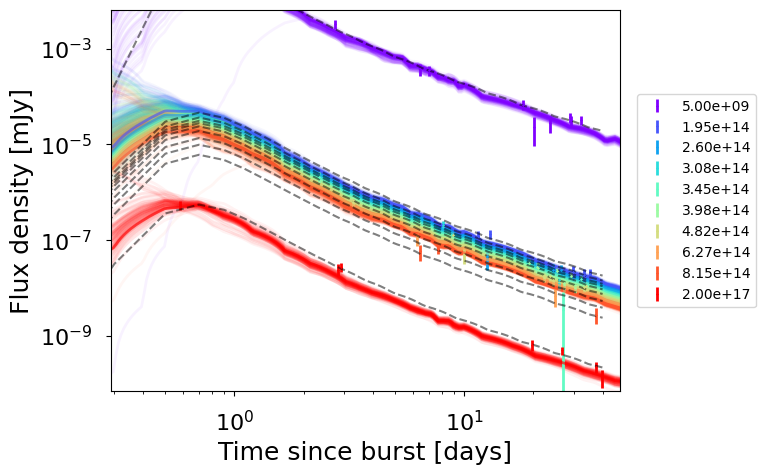

In [34]:
result = redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/tophat_from_emulator/GRBemulator_redback_result.json')
ax=result.plot_lightcurve(show=False)
ax.loglog()
for f in frequencies:
    flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(times, redshift=0.01, av=0.5,
    base_model='tophat_redback',  thv= 0.5, loge0=49.5 , thc= 0.06, logn0=0.5, p=2.3, logepse=-1.25, logepsb=-2.5, xiN=1, g0=1000,
    output_format='flux_density' , frequency=f)
    ax.plot(times, flux, ls='--', color='k', alpha=0.5)
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

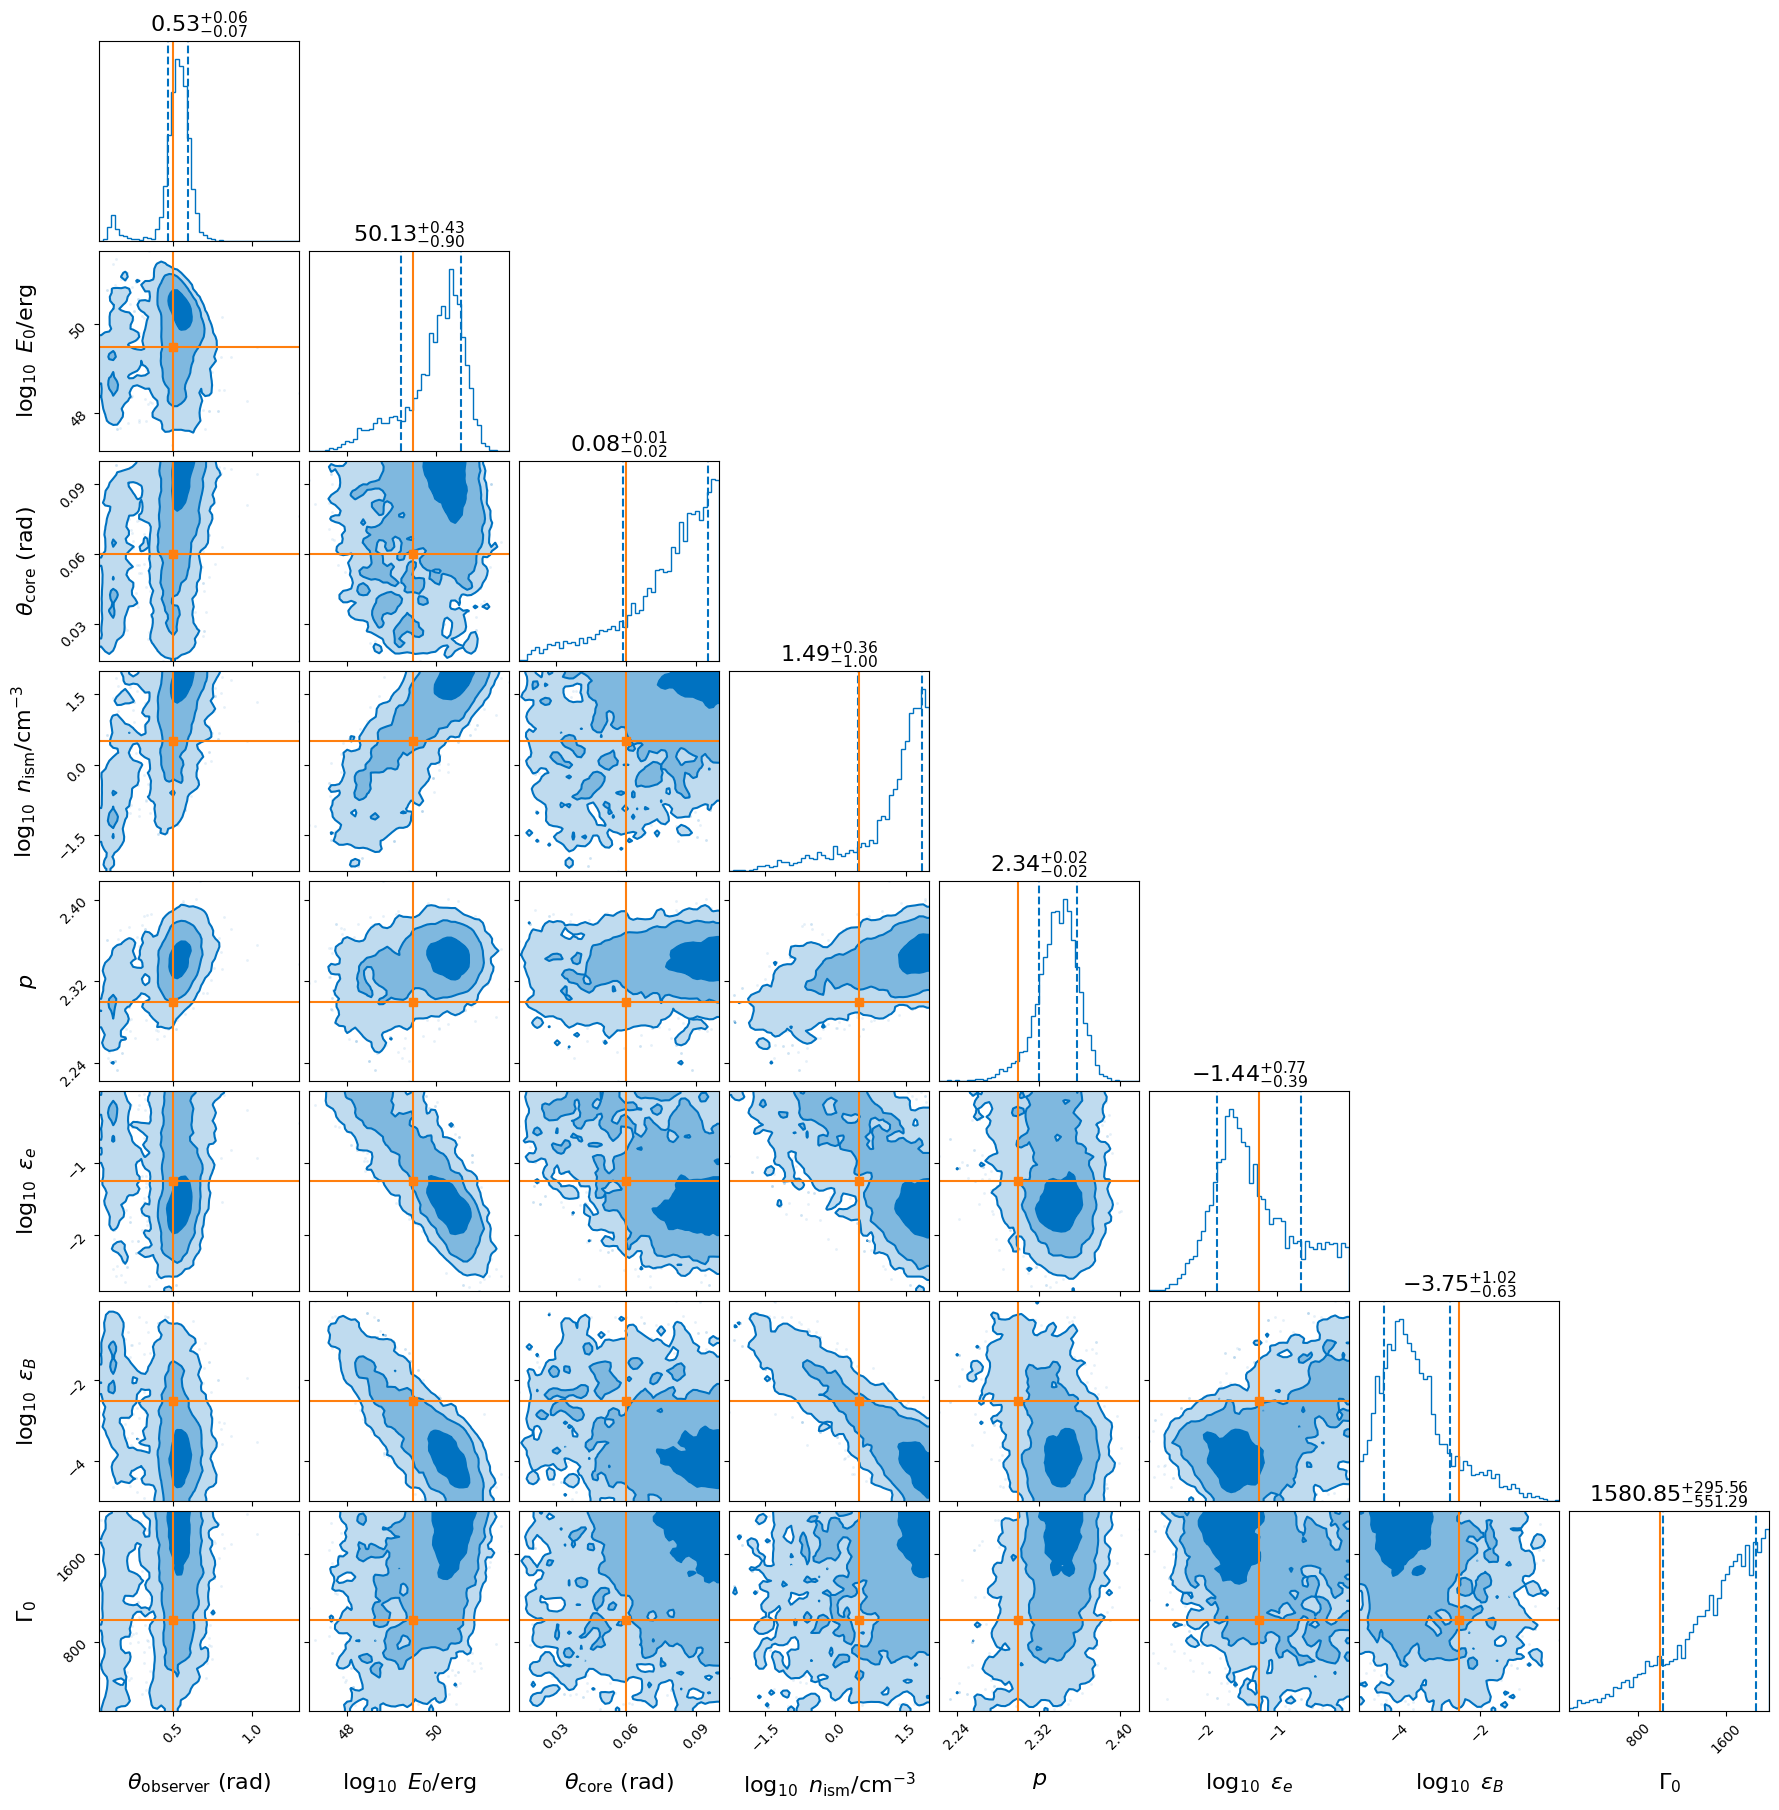

In [35]:
result.plot_corner()

Meta data does not exist for this event.


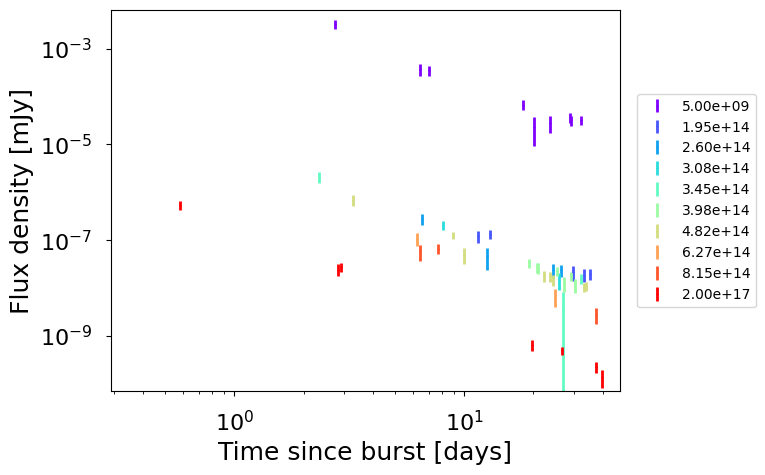

In [40]:
ax1=result.plot_data(show=False)
ax1.loglog()
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

In [15]:
ag_dom_on = redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/tophat_from_emulator/GRBagdominates_on_result.json')
ag_dom_off = redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/tophat_from_emulator/GRBagdominates_off_result.json')
significant_on= redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/tophat_from_emulator/GRBsignificant_on_result.json')
significant_off=redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/tophat_from_emulator/GRBsignificant_off_result.json')

kndom_on= redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/two_layer_stratified_kilonova/GRBkndominate_on_result.json')
kndom_off = redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/two_layer_stratified_kilonova/GRBkndominate_off_result.json')
significant_onk=redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/two_layer_stratified_kilonova/GRBsignificant_onk_result.json')
significant_offk=redback.result.read_in_result('/home/wfw23/Mphys_proj/GRBData/afterglow/flux_density/two_layer_stratified_kilonova/GRBsignificant_offk_result.json')

Meta data does not exist for this event.


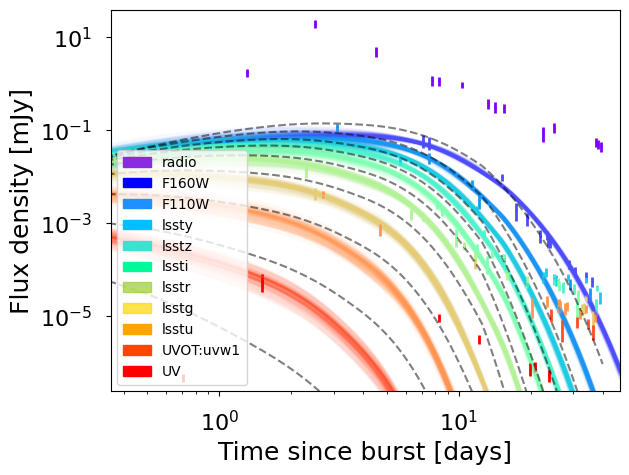

In [26]:
ax=significant_offk.plot_lightcurve(show=False)
for f in frequencies:
    flux= redback.transient_models.extinction_models.extinction_with_kilonova_base_model(times, redshift=0.01, av=0.5, mej=0.03, vej_1=0.1, vej_2=0.4, beta=4,
                                                                                         kappa=5,
                                                                                         base_model='two_layer_stratified_kilonova', frequency=f, output_format='flux_density')
    ax.plot(times, flux, ls='--', color='k', alpha=0.5)
ax.loglog()

f1 = mpatches.Patch(color='blueviolet', label='radio')
f2 = mpatches.Patch(color='b', label='F160W')
f3 = mpatches.Patch(color='dodgerblue', label='F110W')
f4 = mpatches.Patch(color='deepskyblue', label='lssty')
f5 = mpatches.Patch(color='turquoise', label='lsstz')
f6 = mpatches.Patch(color='mediumspringgreen', label='lssti')
f7 = mpatches.Patch(color='yellowgreen', label='lsstr',alpha=0.7)
f8 = mpatches.Patch(color='gold', label='lsstg', alpha=0.7)
f9 = mpatches.Patch(color='orange', label='lsstu')
f10=mpatches.Patch(color='orangered', label='UVOT:uvw1')
f11=mpatches.Patch(color='red', label='UV')
agline=  Line2D([0],[0],color='k', ls='--', label='afterglow', alpha=0.4)
knline=  Line2D([0],[0],color='k', ls=':', label='kilonova', alpha=0.4)
plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11],loc='lower left',bbox_to_anchor=(0, 0))
plt.savefig('q_sigoffk.png', dpi='figure')
plt.show()